In [1]:
from pathlib import Path
from PIL import Image 
import numpy as np 
import matplotlib.pyplot as plt
import os
import torch
import cv2
from torch import nn
import re
import pandas as pd
import random

In [2]:
path = Path('../data/')

img_dir  = path/'train'
mask_dir = path/'train_masks'

def key_from_path(p: Path) -> str:
    return re.sub(r"_mask$", "", p.stem)

# Collect all files
img_paths  = [p for p in img_dir.iterdir() if p.is_file()]
mask_paths = [p for p in mask_dir.iterdir() if p.is_file()]

# Map images and masks by key
images_by_key = {key_from_path(p): p for p in img_paths}
masks_by_key  = {key_from_path(p): p for p in mask_paths}
common_keys   = sorted(images_by_key.keys() & masks_by_key.keys())

# Build DataFrame
df = pd.DataFrame({
    "key":   common_keys,
    "image": [str(images_by_key[k]) for k in common_keys],
    "mask":  [str(masks_by_key[k])  for k in common_keys],
})
print(df.shape)
df.head()

(5088, 3)


,key,image,mask
0,00087a6bd4dc_01,../data/train/00087a6bd4dc_01.jpg,../data/train_masks/00087a6bd4dc_01_mask.gif
1,00087a6bd4dc_02,../data/train/00087a6bd4dc_02.jpg,../data/train_masks/00087a6bd4dc_02_mask.gif
2,00087a6bd4dc_03,../data/train/00087a6bd4dc_03.jpg,../data/train_masks/00087a6bd4dc_03_mask.gif
3,00087a6bd4dc_04,../data/train/00087a6bd4dc_04.jpg,../data/train_masks/00087a6bd4dc_04_mask.gif
4,00087a6bd4dc_05,../data/train/00087a6bd4dc_05.jpg,../data/train_masks/00087a6bd4dc_05_mask.gif


In [3]:
import segmentation_models_pytorch as smp

def build_model():
    model = smp.Unet(
        encoder_name="efficientnet-b0",      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=1,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to('cpu')
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
    model.eval()
    return model

/home/sonu/codes/learning/Carvana-Image-Masking-Challenge/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    # img = np.tile(img[...,None], [1, 1, 3]) # gray to rgb
    img = img.astype('float32') # original is uint16
    mx = np.max(img)
    if mx:
        img/=mx # scale image to [0, 1]
    return img

def load_msk(path):
    msk = np.array(Image.open(path))
    # msk = np.load(path)
    msk = msk.astype('float32')
    # msk/=255.0
    return msk

In [5]:
def preprocess_img(img_path):
    img = load_img(img_path)
    img = cv2.resize(img, (224, 224))
    img = np.transpose(img, (2, 0, 1))
    img = np.expand_dims(img, axis=0)
    return torch.from_numpy(img)

In [6]:
model = load_model('../best_epoch-00.bin')

# Make Prediction

In [7]:
img_path = df.iloc[0]['image']
img = preprocess_img(img_path)

pred = model(img)
pred = (nn.Sigmoid()(pred)>0.5).double()
pred = pred.squeeze().cpu().numpy()

# Prediction

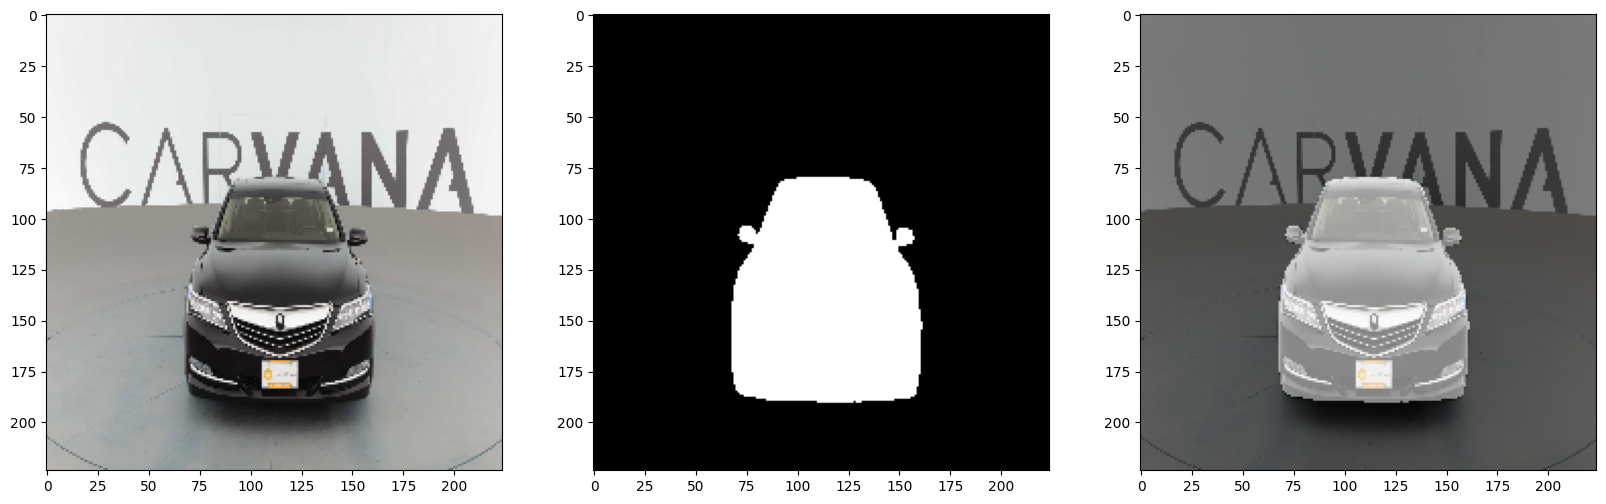

In [8]:
img = np.transpose(img.squeeze(), (1, 2, 0))
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(img)

plt.subplot(1, 3, 2)
plt.imshow(pred, cmap='grey')

plt.subplot(1, 3, 3)
plt.imshow(img)
plt.imshow(pred, alpha=0.5, cmap='grey')

plt.show()

# Dice Loss between GT and resized prediction

In [9]:
def dice_coef(y_true, y_pred, thr=0.5, epsilon=1e-3):
    y_true = y_true.astype(np.float32)
    y_pred = (y_pred > thr).astype(np.float32)

    intersection = np.sum(y_true * y_pred)
    denominator = np.sum(y_true) + np.sum(y_pred)

    dice = (2 * intersection + epsilon) / (denominator + epsilon)
    return dice


def dice_coef_fg_bg(y_true, y_pred, thr=0.5, epsilon=1e-3):
    y_true = y_true.astype(np.float32)
    y_pred = (y_pred > thr).astype(np.float32)

    # Foreground: class 1
    inter_fg = np.sum(y_true * y_pred)
    den_fg = np.sum(y_true) + np.sum(y_pred)
    dice_fg = (2 * inter_fg + epsilon) / (den_fg + epsilon)

    # Background: class 0
    y_true_bg = 1 - y_true
    y_pred_bg = 1 - y_pred
    inter_bg = np.sum(y_true_bg * y_pred_bg)
    den_bg = np.sum(y_true_bg) + np.sum(y_pred_bg)
    dice_bg = (2 * inter_bg + epsilon) / (den_bg + epsilon)

    return dice_fg, dice_bg


# Prediction vs GT 

Dice score of foreground and background is (np.float32(0.9929865), np.float32(0.9976525))


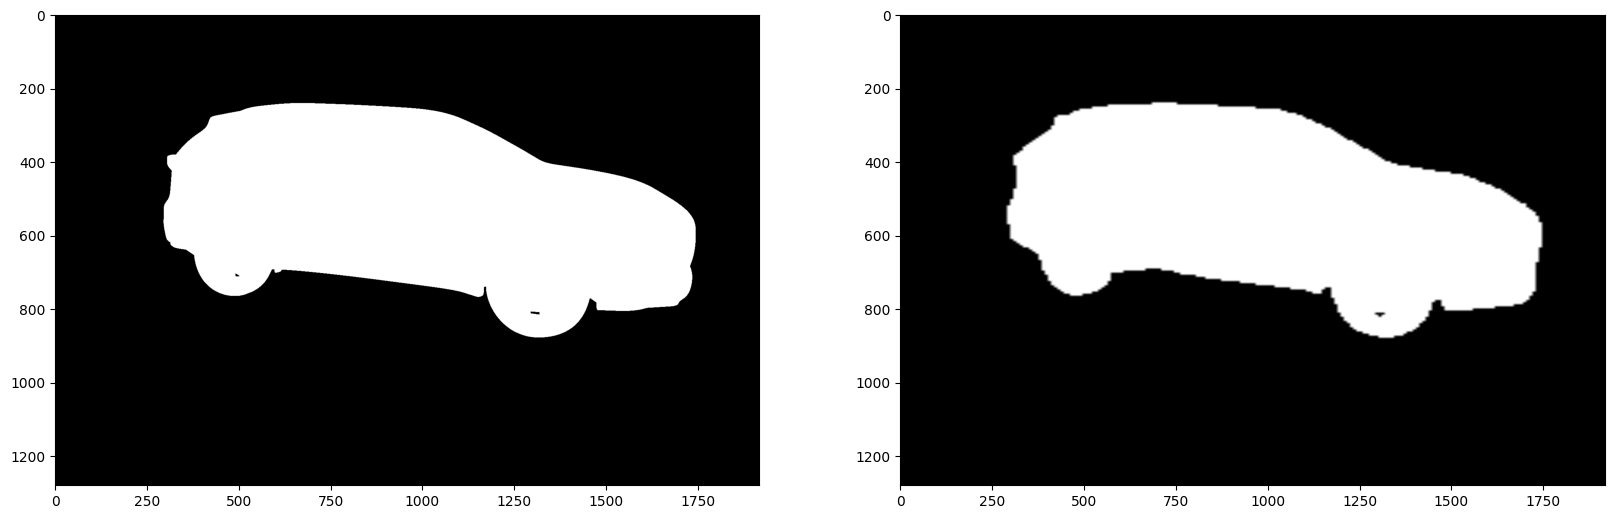

In [10]:
random_idx = random.randint(0, len(df)-1)
name, img_path, mask = df.iloc[random_idx]
img = preprocess_img(img_path)

pred = model(img)
pred = (nn.Sigmoid()(pred)>0.5).double()
pred = pred.squeeze().cpu().numpy()

# load originam mask
mask = load_msk(mask)
# resized predicted mask to original img siz3
pred_resized = cv2.resize(pred, dsize=(1918, 1280))

# compute loss
print('Dice score of foreground and background is', dice_coef_fg_bg(mask, pred_resized))

# plot result
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap='grey')

plt.subplot(1, 2, 2)
plt.imshow(pred_resized, cmap='grey')

plt.show()

Dice score of foreground and background is (np.float32(0.9939441), np.float32(0.99815035))


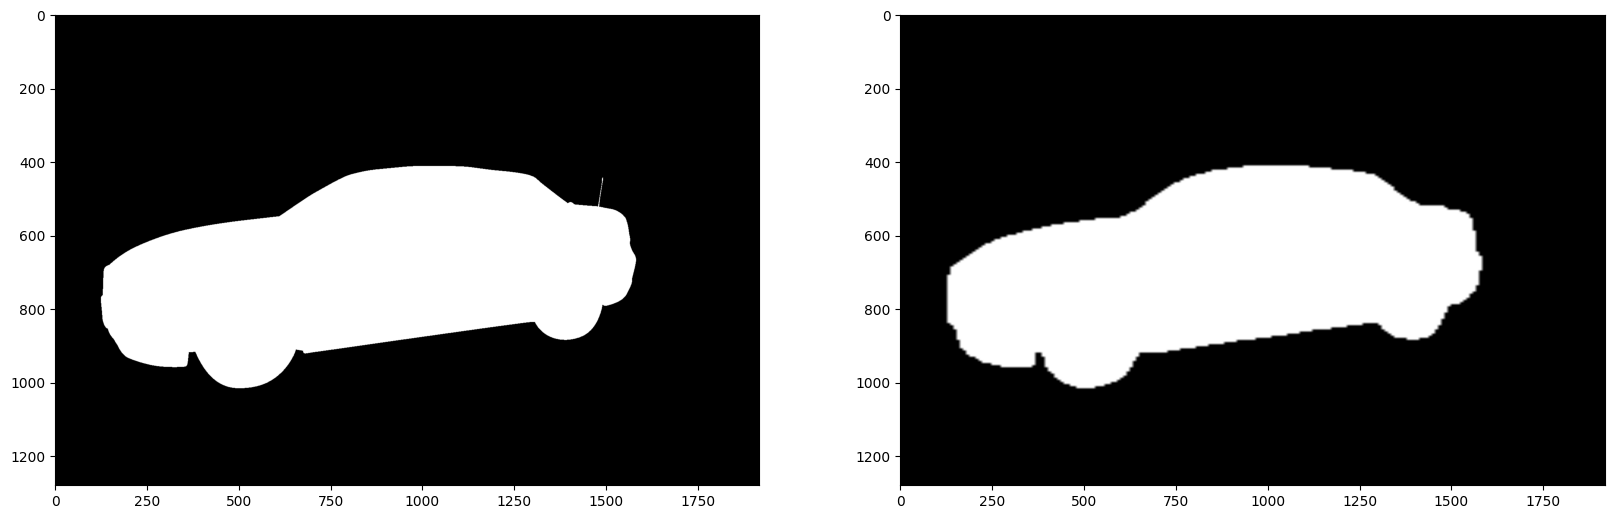

In [11]:
random_idx = random.randint(0, len(df)-1)
name, img_path, mask = df.iloc[random_idx]
img = preprocess_img(img_path)

pred = model(img)
pred = (nn.Sigmoid()(pred)>0.5).double()
pred = pred.squeeze().cpu().numpy()

# load originam mask
mask = load_msk(mask)
# resized predicted mask to original img siz3
pred_resized = cv2.resize(pred, dsize=(1918, 1280))

# compute loss
print('Dice score of foreground and background is', dice_coef_fg_bg(mask, pred_resized))

# plot result
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap='grey')

plt.subplot(1, 2, 2)
plt.imshow(pred_resized, cmap='grey')

plt.show()

Dice Loss of foreground and background is (np.float32(0.993247), np.float32(0.99787974))


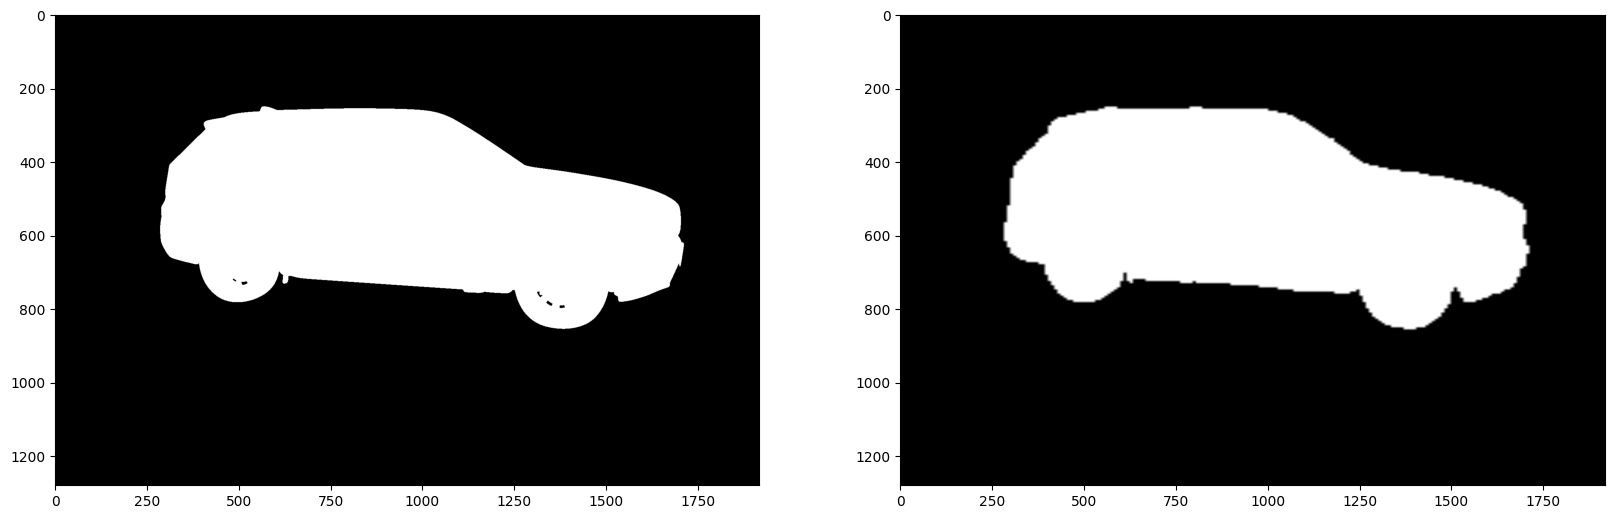

In [12]:
random_idx = random.randint(0, len(df)-1)
name, img_path, mask = df.iloc[random_idx]
img = preprocess_img(img_path)

pred = model(img)
pred = (nn.Sigmoid()(pred)>0.5).double()
pred = pred.squeeze().cpu().numpy()

# load originam mask
mask = load_msk(mask)
# resized predicted mask to original img siz3
pred_resized = cv2.resize(pred, dsize=(1918, 1280))

# compute loss
print('Dice Loss of foreground and background is', dice_coef_fg_bg(mask, pred_resized))

# plot result
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap='grey')

plt.subplot(1, 2, 2)
plt.imshow(pred_resized, cmap='grey')

plt.show()